# MakePlotsForHCERES2024

https://github.com/JospehCeh/PhotoZ_PhD/blob/u/dagoret/StudyFors2SED/ReadFors2spectrafromh5.ipynb

https://www.christopherlovell.co.uk/blog/2016/04/27/h5py-intro.html


- creation date : 2024-01-21
- update : 2024-01-22

In [1]:
import os,sys,re
import h5py # one standard python package to work on hdf5 file
import tables #naother python package to work on df5 file and have dump capabilities

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import seaborn as sns 
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
import pandas as pd

In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)


In [3]:
# SMOOTHING

def smooth_data_convolve_my_average(arr, span):
    re = np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

    # The "my_average" part: shrinks the averaging window on the side that 
    # reaches beyond the data, keeps the other side the same size as given 
    # by "span"
    re[0] = np.average(arr[:span])
    for i in range(1, span + 1):
        re[i] = np.average(arr[:i + span])
        re[-i] = np.average(arr[-i - span:])
    return re

def smooth_data_np_average(arr, span):  # my original, naive approach
    return [np.average(arr[val - span:val + span + 1]) for val in range(len(arr))]

def smooth_data_np_convolve(arr, span):
    return np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

def smooth_data_np_cumsum_my_average(arr, span):
    cumsum_vec = np.cumsum(arr)
    moving_average = (cumsum_vec[2 * span:] - cumsum_vec[:-2 * span]) / (2 * span)

    # The "my_average" part again. Slightly different to before, because the
    # moving average from cumsum is shorter than the input and needs to be padded
    front, back = [np.average(arr[:span])], []
    for i in range(1, span):
        front.append(np.average(arr[:i + span]))
        back.insert(0, np.average(arr[-i - span:]))
    back.insert(0, np.average(arr[-2 * span:]))
    return np.concatenate((front, moving_average, back))

def smooth_data_lowess(arr, span):
    x = np.linspace(0, 1, len(arr))
    return sm.nonparametric.lowess(arr, x, frac=(5*span / len(arr)), return_sorted=False)

def smooth_data_kernel_regression(arr, span):
    # "span" smoothing parameter is ignored. If you know how to 
    # incorporate that with kernel regression, please comment below.
    kr = KernelReg(arr, np.linspace(0, 1, len(arr)), 'c')
    return kr.fit()[0]

def smooth_data_savgol_0(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 0)

def smooth_data_savgol_1(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 1)

def smooth_data_savgol_2(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 2)

def smooth_data_fft(arr, span):  # the scaling of "span" is open to suggestions
    w = fftpack.rfft(arr)
    spectrum = w ** 2
    cutoff_idx = spectrum < (spectrum.max() * (1 - np.exp(-span / 2000)))
    w[cutoff_idx] = 0
    return fftpack.irfft(w)


In [4]:
def get_all(name):
    """
    Use it with  hf.visit(get_all)
    Then it will print all groups, subgroups and datasets
    Note this function returns nothing so it cannot be used to retrieve somthing
    it will keep iterating.
    """
    print(name)

In [5]:
def print_attrs(name, obj):
    """
    Use it with hf.visititems(print_attrs)
    """
    for key, val in obj.attrs.items():
        print("  %s  %s: %s" % (name,key, val))

In [6]:
def get_attrs(name,obj):
    d = {}
    for key, val in obj.attrs.items():
        d[key] = val
    return d


In [7]:
# list all attributes
# hf.visititems(print_attrs)

In [8]:
def get_objects_group(name, obj):
    """
    hf.visititems(get_objects_group)
    act as a kind of filter
    """
    if isinstance(obj,h5py.Group):
        print("\t >>> ",name,'is a Group')
    return obj

In [9]:
def get_objects_dataset(name, obj):
    """
    hf.visititems(get_objects_dataset)
    act as a kind of filter
    """
    if isinstance(obj,h5py.Dataset):
            print("\t >>> ", name,'is a Dataset')
    return obj

In [10]:
# get all the name of the groups nd datasets , not the attributes
#hf.visit(get_all)

In [11]:
path = "Data_Auxtel_Spectro"

In [12]:
list_of_files = sorted(os.listdir(path))
list_of_files

['spectra_transmission_ratio_20230927.h5',
 'spectra_transmission_ratio_20230928.h5',
 'spectra_transmission_ratio_20231010.h5',
 'spectra_transmission_ratio_20231107.h5',
 'spectra_transmission_ratio_20231113.h5',
 'spectra_transmission_ratio_20231114.h5',
 'spectra_transmission_ratio_20231115.h5',
 'spectra_transmission_ratio_20231116.h5',
 'spectra_transmission_ratio_20231120.h5',
 'spectra_transmission_ratio_20231127.h5',
 'spectra_transmission_ratio_20231128.h5',
 'spectra_transmission_ratio_20231129.h5',
 'spectra_transmission_ratio_20231130.h5',
 'spectra_transmission_ratio_20231204.h5',
 'spectra_transmission_ratio_20231205.h5',
 'spectra_transmission_ratio_20231206.h5',
 'spectra_transmission_ratio_20231207.h5']

## Open the selected 

In [13]:
#DATEOBS = 20231010
DATEOBS = 20231127
base_filename = f"spectra_transmission_ratio_{DATEOBS}.h5"
filename = os.path.join(path,base_filename)

In [14]:
# Dump the file
#the_table = tables.open_file(filename, mode="r")
#the_table

In [15]:
hf = h5py.File(filename, 'r')

In [16]:
# Best way to dump the content of a file
hf.visititems(print_attrs)

  median_param_atm  md_PWV: 3.5517703829393223
  median_param_atm  md_VAOD: 0.004200960138097141
  median_param_atm  md_grey: 0.9675833250286704
  median_param_atm  md_ozone: 305.8840925062365
  sim_spec  PWV: 3.5517703829393223
  sim_spec  VAOD: 0.004200960138097141
  sim_spec  ozone: 305.8840925062365
  spec_2023112700067  PWV: 3.2764135412618764
  spec_2023112700067  VAOD: 0.004683676794729051
  spec_2023112700067  airmass: 1.37033739370972
  spec_2023112700067  flag_atmparam: 1
  spec_2023112700067  grey: 0.9675833250286704
  spec_2023112700067  ozone: 324.2983658911808
  spec_2023112700067  target: HD205905
  spec_2023112700073  PWV: 3.514433481040779
  spec_2023112700073  VAOD: 0.0
  spec_2023112700073  airmass: 1.92142440284357
  spec_2023112700073  flag_atmparam: 1
  spec_2023112700073  grey: 0.9675833250286704
  spec_2023112700073  ozone: 281.1064065728363
  spec_2023112700073  target: HD185975
  spec_2023112700074  PWV: 3.402685467463114
  spec_2023112700074  VAOD: 0.0
  spec

In [17]:
list(hf.keys())

['median_param_atm',
 'sim_spec',
 'spec_2023112700067',
 'spec_2023112700073',
 'spec_2023112700074',
 'spec_2023112700094',
 'spec_2023112700115',
 'spec_2023112700116',
 'spec_2023112700122',
 'spec_2023112700123',
 'spec_2023112700147',
 'spec_2023112700148',
 'spec_2023112700168',
 'spec_2023112700175',
 'spec_2023112700183',
 'spec_2023112700196',
 'spec_2023112700211',
 'spec_2023112700403',
 'spec_2023112700404']

## Read all the attributes and the datasets for all top level group in this loop

In [18]:
all_attributes = {}
all_datasets = {}
list_of_keys = list(hf.keys())

# loop on each key of top level groups
for key in list_of_keys: 
    group = hf.get(key)
    
    # retrieve all attributes for each group
    all_attributes[key] = get_attrs(key,group)

    datasets = {}
    for name, h5obj in group.items():
        if isinstance(h5obj,h5py.Group):
            # just check if there are subgroups that would need to be red recursively
            print("\t >>> ",key,' / ',name,'is a Group')
         
        elif isinstance(h5obj,h5py.Dataset):
            print("\t >>> ", key , name,'is a Dataset')
            arr = h5obj[:]
            #arr = hf[name][:] # same thing
            # add that dataset to the current group datasets
            datasets[name] = arr
    
    all_datasets[key] = datasets  

	 >>>  sim_spec transm is a Dataset
	 >>>  sim_spec wls is a Dataset
	 >>>  spec_2023112700067 fls is a Dataset
	 >>>  spec_2023112700067 fls_err is a Dataset
	 >>>  spec_2023112700067 ratio is a Dataset
	 >>>  spec_2023112700067 ratio_airmass1 is a Dataset
	 >>>  spec_2023112700067 ratio_err is a Dataset
	 >>>  spec_2023112700067 wlr is a Dataset
	 >>>  spec_2023112700067 wls is a Dataset
	 >>>  spec_2023112700073 fls is a Dataset
	 >>>  spec_2023112700073 fls_err is a Dataset
	 >>>  spec_2023112700073 ratio is a Dataset
	 >>>  spec_2023112700073 ratio_airmass1 is a Dataset
	 >>>  spec_2023112700073 ratio_err is a Dataset
	 >>>  spec_2023112700073 wlr is a Dataset
	 >>>  spec_2023112700073 wls is a Dataset
	 >>>  spec_2023112700074 fls is a Dataset
	 >>>  spec_2023112700074 fls_err is a Dataset
	 >>>  spec_2023112700074 ratio is a Dataset
	 >>>  spec_2023112700074 ratio_airmass1 is a Dataset
	 >>>  spec_2023112700074 ratio_err is a Dataset
	 >>>  spec_2023112700074 wlr is a Dataset
	 

In [19]:
#all_attributes

In [20]:
#all_datasets

## Retrieve the list of observed spectra

### Selection of good Spectra

In [21]:
spec_nums_list = ["spec_" + re.findall("^spec_(.*)", keyname)[0] for keyname in list_of_keys if len(re.findall("^spec_(.*)", keyname)) > 0 ] 

In [22]:
print(spec_nums_list)

['spec_2023112700067', 'spec_2023112700073', 'spec_2023112700074', 'spec_2023112700094', 'spec_2023112700115', 'spec_2023112700116', 'spec_2023112700122', 'spec_2023112700123', 'spec_2023112700147', 'spec_2023112700148', 'spec_2023112700168', 'spec_2023112700175', 'spec_2023112700183', 'spec_2023112700196', 'spec_2023112700211', 'spec_2023112700403', 'spec_2023112700404']


In [23]:
Nspec = len(spec_nums_list)
cmap = sns.color_palette("hls", Nspec)

{'PWV': 3.2764135412618764, 'VAOD': 0.004683676794729051, 'airmass': 1.37033739370972, 'flag_atmparam': 1, 'grey': 0.9675833250286704, 'ozone': 324.2983658911808, 'target': 'HD205905'}


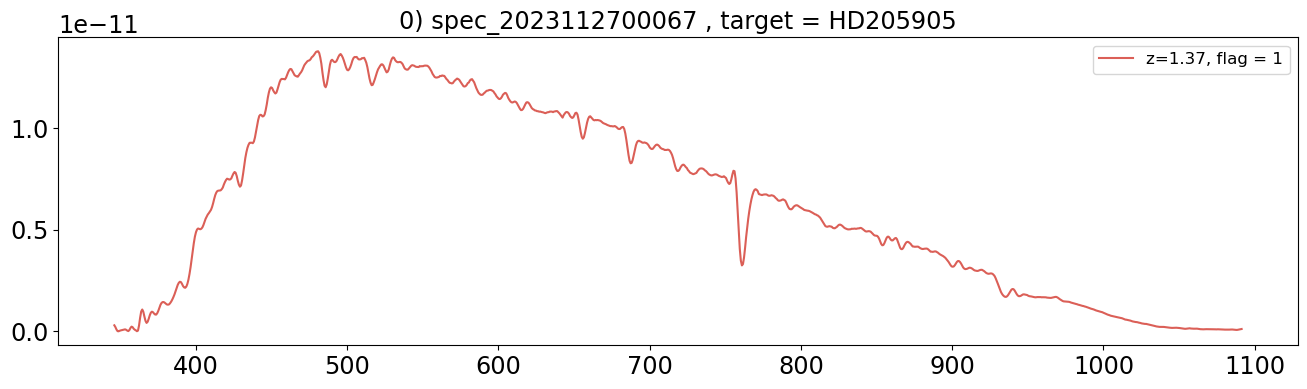

{'PWV': 3.514433481040779, 'VAOD': 0.0, 'airmass': 1.92142440284357, 'flag_atmparam': 1, 'grey': 0.9675833250286704, 'ozone': 281.1064065728363, 'target': 'HD185975'}


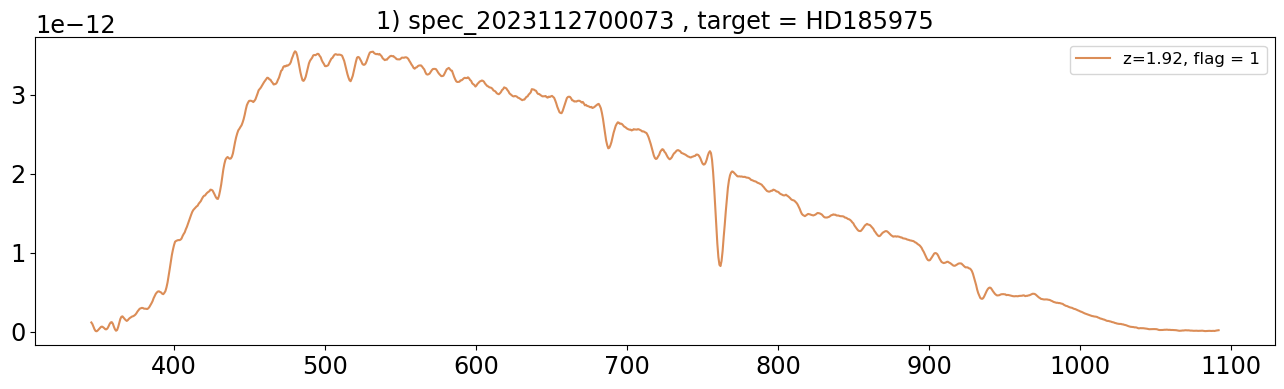

{'PWV': 3.402685467463114, 'VAOD': 0.0, 'airmass': 1.92212006775784, 'flag_atmparam': 1, 'grey': 0.9675833250286704, 'ozone': 295.4467691945665, 'target': 'HD185975'}


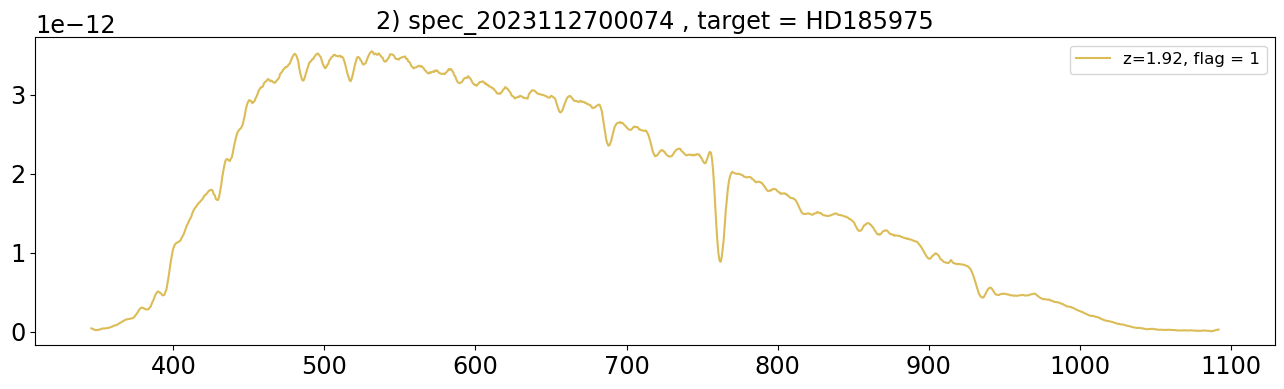

{'PWV': 3.200398463363562, 'VAOD': 2.996710288644764e-10, 'airmass': 1.58714012183517, 'flag_atmparam': 1, 'grey': 0.9675833250286704, 'ozone': 296.8630175417451, 'target': 'HD205905'}


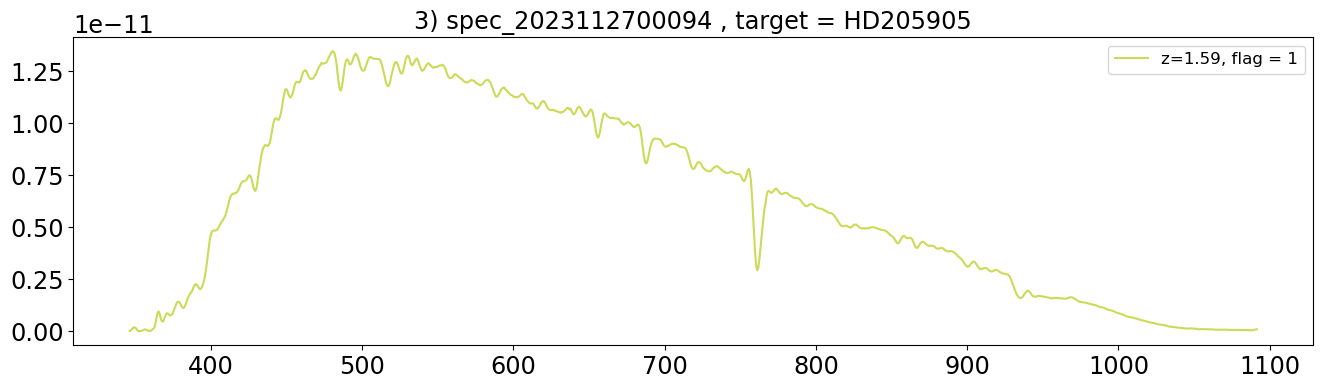

{'PWV': 3.5517703829393223, 'VAOD': 0.0, 'airmass': 1.95607235587472, 'flag_atmparam': 1, 'grey': 0.9675833250286704, 'ozone': 285.00999346986373, 'target': 'HD185975'}


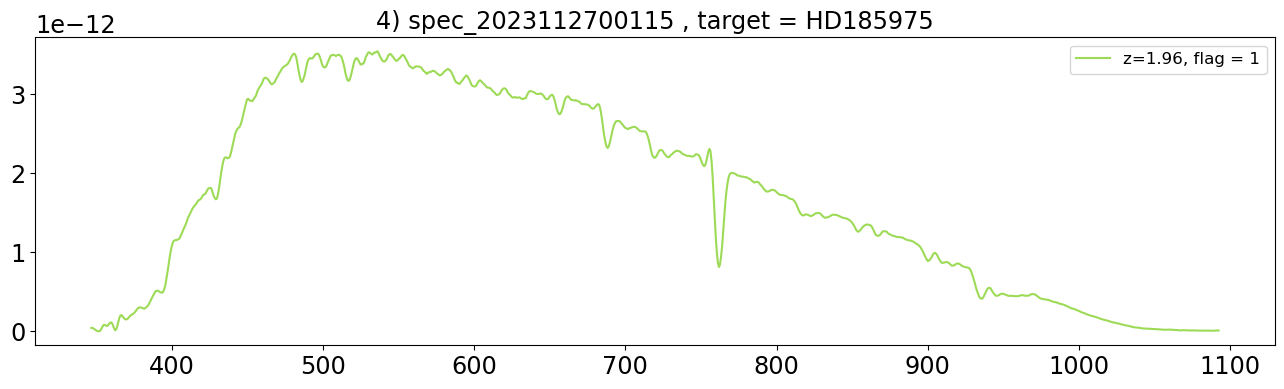

{'PWV': 3.5974795829232185, 'VAOD': 0.0, 'airmass': 1.95684512476475, 'flag_atmparam': 1, 'grey': 0.9675833250286704, 'ozone': 311.3179142932174, 'target': 'HD185975'}


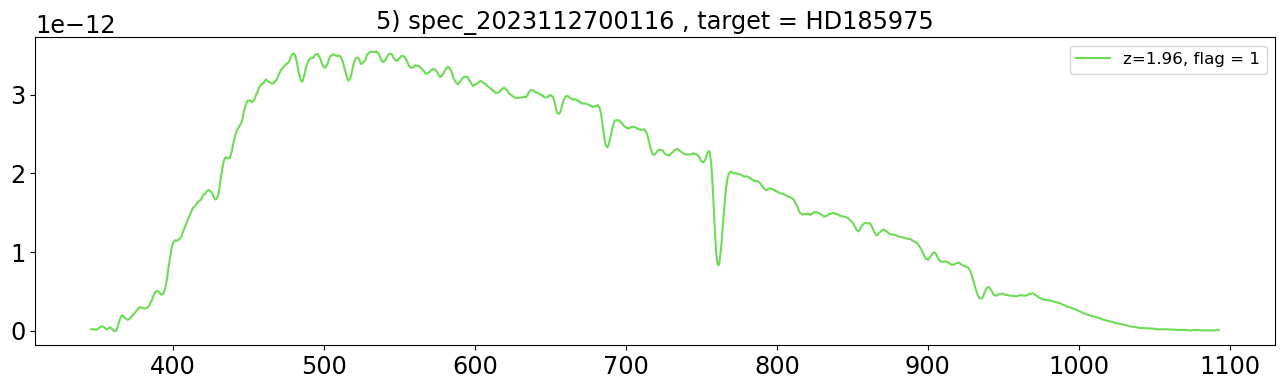

{'PWV': 3.8043508120691167, 'VAOD': 0.004200960138097141, 'airmass': 1.92981693377834, 'flag_atmparam': 1, 'grey': 0.9675833250286704, 'ozone': 297.0540631549385, 'target': 'HD205905'}


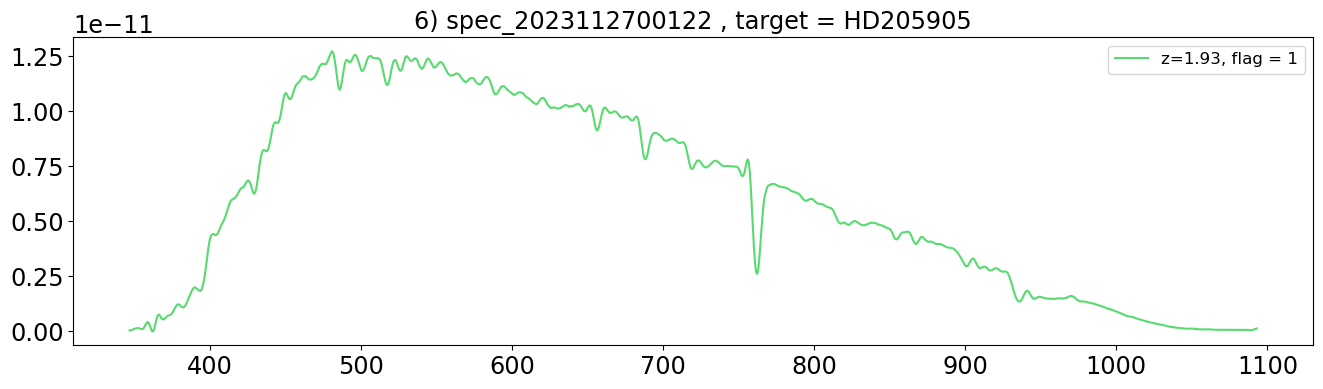

{'PWV': 3.6919284778550736, 'VAOD': 0.0010276965161042549, 'airmass': 1.94395807802772, 'flag_atmparam': 1, 'grey': 0.9675833250286704, 'ozone': 305.0103714323357, 'target': 'HD205905'}


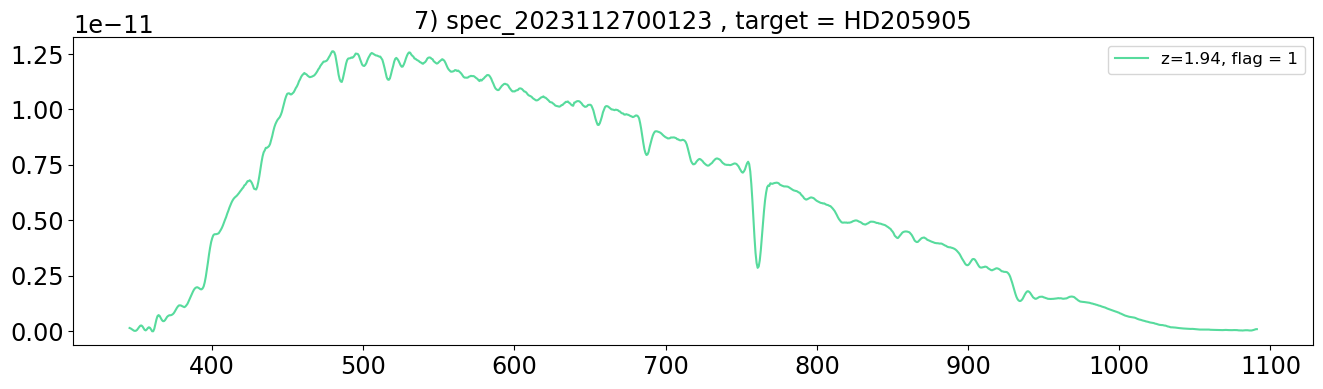

{'PWV': 3.7195142588354324, 'VAOD': 0.01327565095344493, 'airmass': 1.12654354434594, 'flag_atmparam': 1, 'grey': 0.9675833250286704, 'ozone': 354.107296100824, 'target': 'HD2811'}


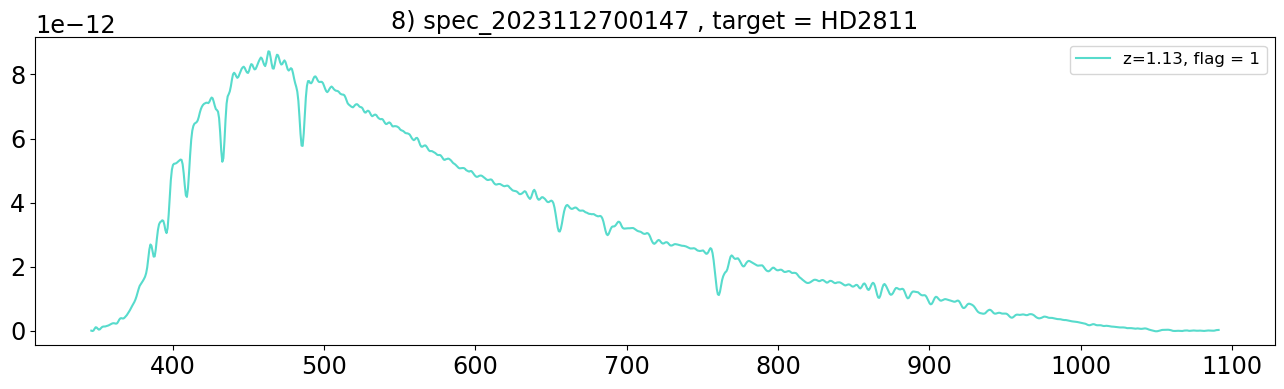

{'PWV': 3.2597803342617024, 'VAOD': 0.015746438366886727, 'airmass': 1.12869314872288, 'flag_atmparam': 1, 'grey': 0.9675833250286704, 'ozone': 332.8832069739918, 'target': 'HD2811'}


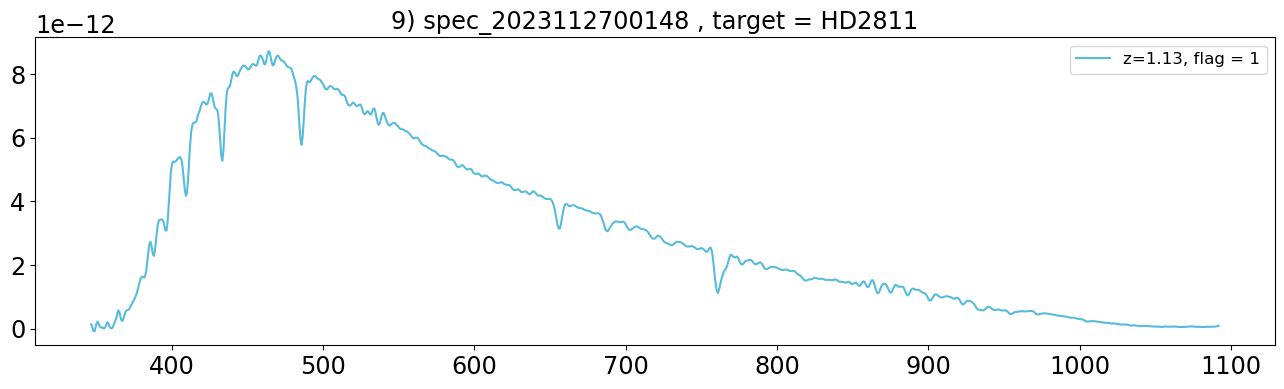

{'PWV': 3.905736298079652, 'VAOD': 0.010563204345497765, 'airmass': 1.18243927172824, 'flag_atmparam': 1, 'grey': 0.9675833250286704, 'ozone': 358.2236312477792, 'target': 'HD2811'}


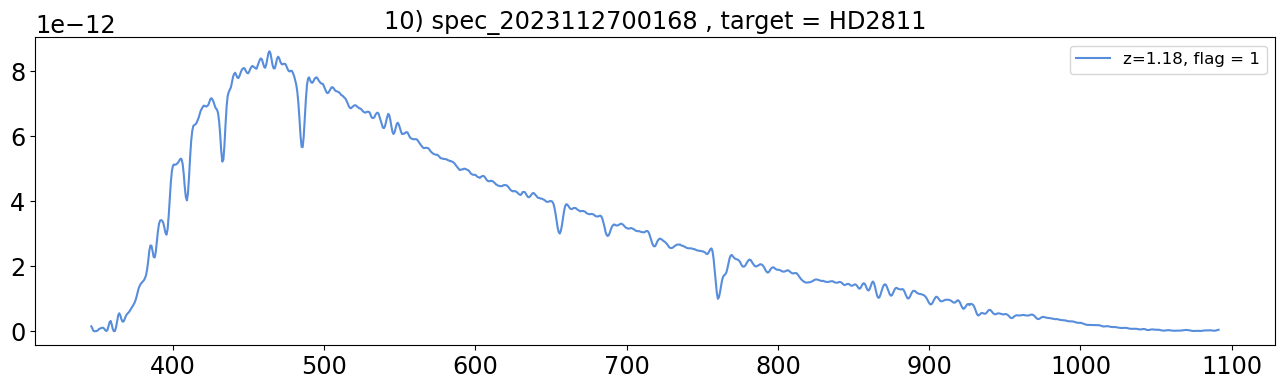

{'PWV': 3.9297020493970605, 'VAOD': 0.0, 'airmass': 2.00055421259165, 'flag_atmparam': 1, 'grey': 0.9675833250286704, 'ozone': 305.5054209396168, 'target': 'HD185975'}


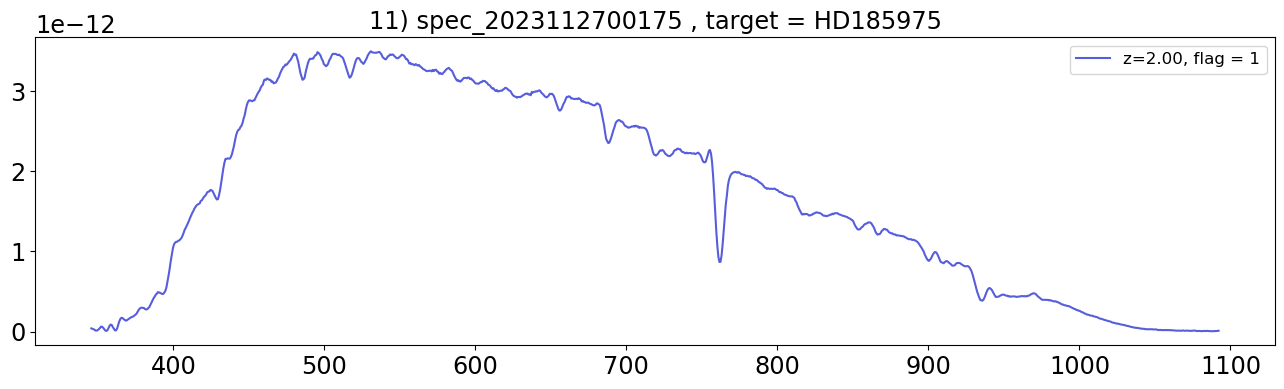

{'PWV': 3.603757978084497, 'VAOD': 0.013137076602734832, 'airmass': 1.23275027501265, 'flag_atmparam': 1, 'grey': 0.9675833250286704, 'ozone': 337.28363941662724, 'target': 'HD2811'}


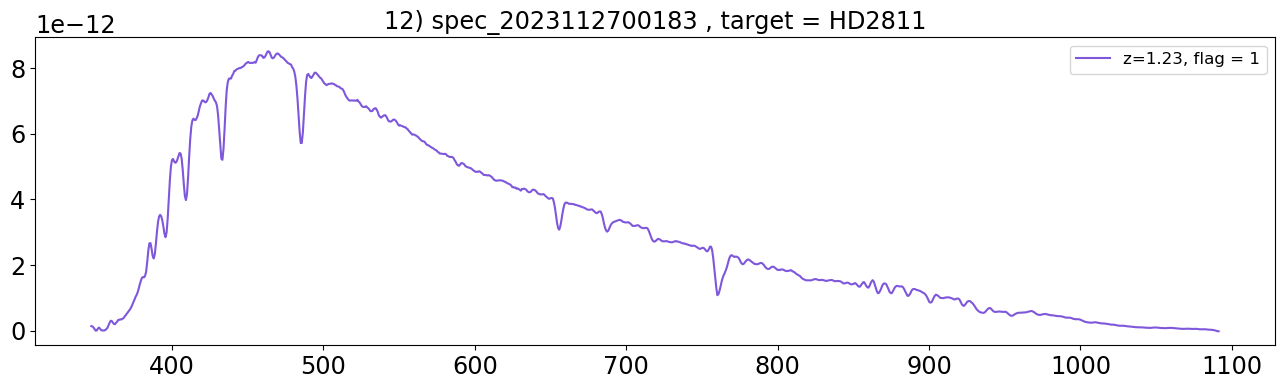

{'PWV': 3.486603709093691, 'VAOD': 0.01425106777930838, 'airmass': 1.28646083308191, 'flag_atmparam': 1, 'grey': 0.9675833250286704, 'ozone': 317.5698840470964, 'target': 'HD2811'}


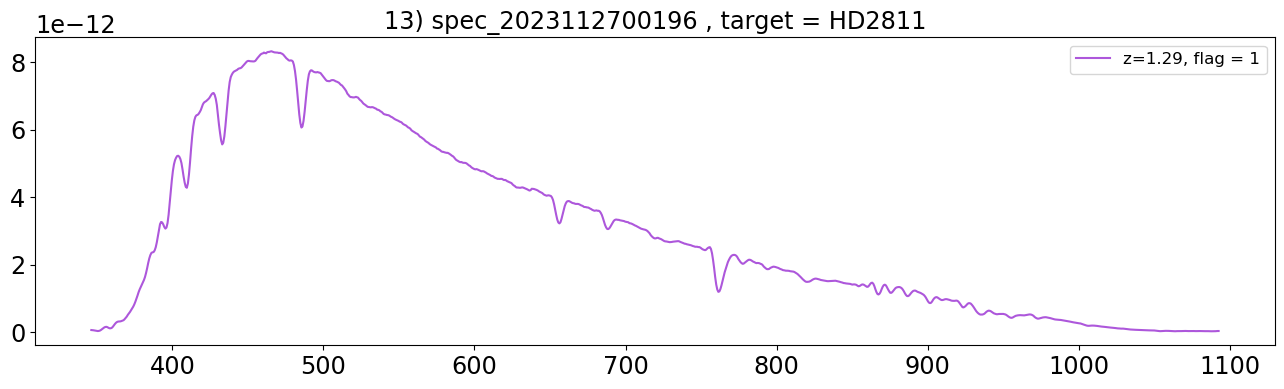

{'PWV': 3.5579419393404663, 'VAOD': 0.007425297804659009, 'airmass': 1.35963946813355, 'flag_atmparam': 1, 'grey': 0.9675833250286704, 'ozone': 295.45240965022856, 'target': 'HD2811'}


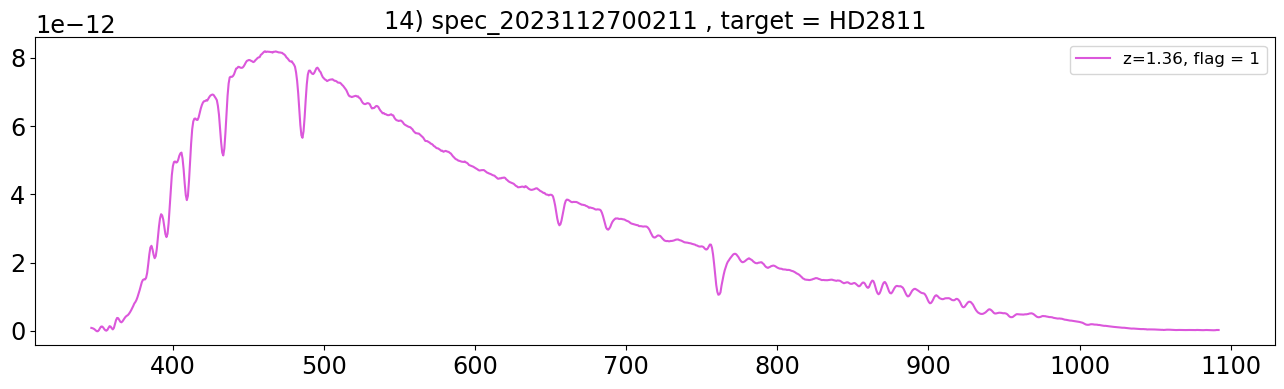

{'PWV': 2.851868983692298, 'VAOD': 0.006991669103741538, 'airmass': 2.14256249399399, 'flag_atmparam': 1, 'grey': 0.9675833250286704, 'ozone': 305.8840925062365, 'target': 'HD185975'}


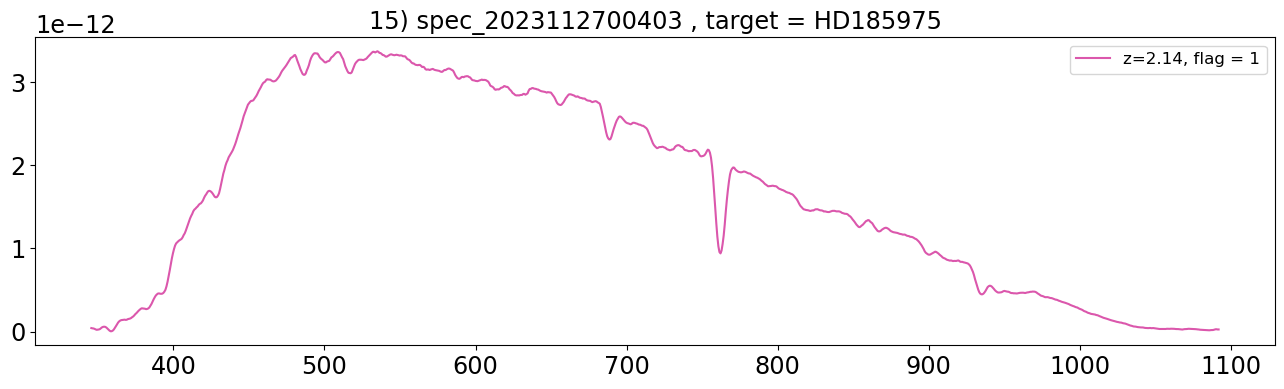

{'PWV': 2.715143660362847, 'VAOD': 0.0, 'airmass': 2.14268471157553, 'flag_atmparam': 1, 'grey': 0.9675833250286704, 'ozone': 316.0429972388402, 'target': 'HD185975'}


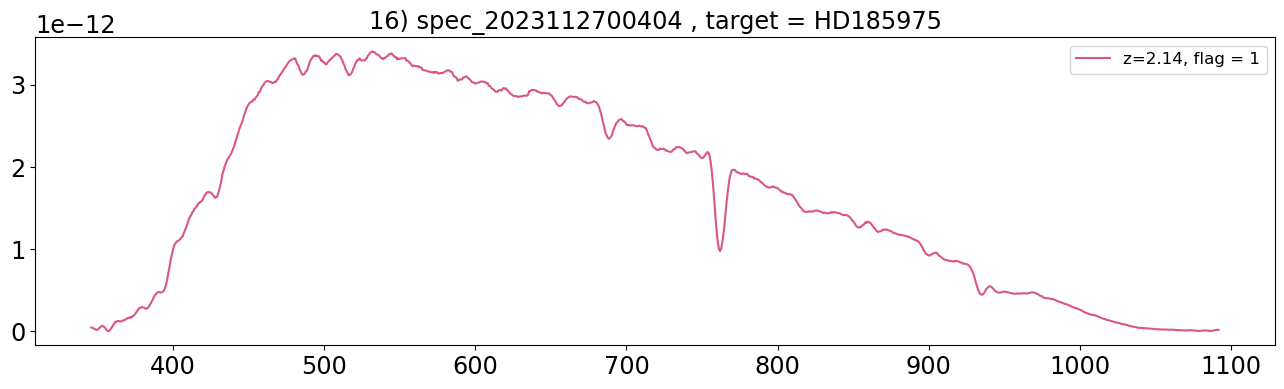

In [24]:
all_targets = []
my_flags = []
for idx,spec_num in enumerate(spec_nums_list):
    the_dataset = all_datasets[spec_num]
    the_attrs = all_attributes[spec_num]
    the_target = the_attrs['target']
    all_targets.append(the_target)
    the_airmass = the_attrs['airmass']
    the_flag = the_attrs['flag_atmparam']
    the_title = f"{idx}) {spec_num} , target = {the_target}"
    the_label = f"z={the_airmass:.2f}, flag = {the_flag}"
    the_color = cmap[idx]
    print(the_attrs)
    wls = the_dataset['wls']
    fls = the_dataset['fls']
    fls_err = the_dataset['fls_err']
    fig,ax = plt.subplots(1,1,figsize=(16,4))
    #ax.errorbar(wls,fls, yerr=fls_err, xerr=0.0,fmt='+', ecolor="grey", elinewidth=0, capsize=12,color="r",label=the_label )
    ax.plot(wls,fls,color=the_color,label=the_label )
    ax.legend()
    ax.set_title(the_title)

    if spec_num in ['spec_2023101000451','spec_2023101000631', 'spec_2023101000638']:
        my_flags.append(False)
    else:
        my_flags.append(True)
        
    plt.show()

### Plot for the hceres

In [25]:
targets_unique = np.unique(all_targets)
Ntags = len(targets_unique )

In [26]:
#cmap = sns.color_palette("hls", Ntags)
cmap = sns.color_palette("husl", Ntags)

In [27]:
atm = all_attributes['median_param_atm']

In [28]:
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
textstr = '\n'.join((
    r'$PWV=%.3f$ mm' % (atm["md_PWV"], ),
    r'$ozone=%.1f$ DU' % (atm["md_ozone"], ),
    r'$VAOD=%.3f$' % (atm['md_VAOD'], )))

In [29]:
def convertNumToDatestr(num):
    year = num//10_000
    month= (num-year*10_000)//100
    day = (num-year*10_000-month*100)

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return datestr

DATEOBS_STR = convertNumToDatestr(DATEOBS)

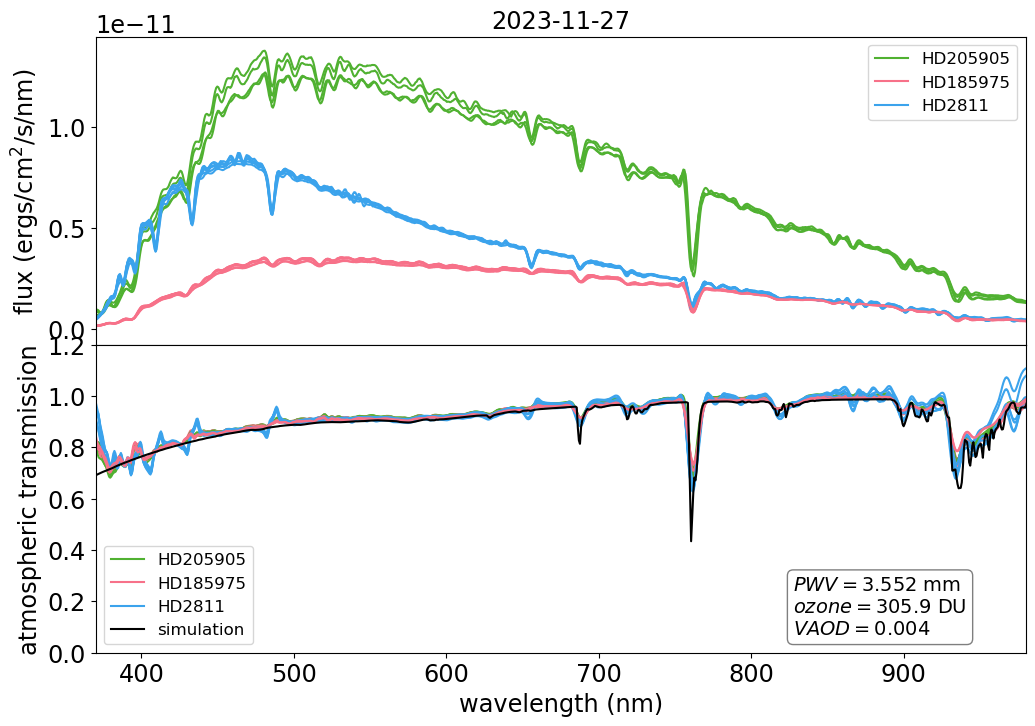

In [30]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,8),sharex=True)

color_counts = np.zeros(Ntags)
for idx,spec_num in enumerate(spec_nums_list):
    the_dataset = all_datasets[spec_num]
    the_attrs = all_attributes[spec_num]
    the_target = the_attrs['target']

    the_label = the_target
    idxc = np.where(targets_unique== the_target )[0][0]
    the_col = cmap[idxc]
    
 
    all_targets.append(the_target)
    the_airmass = the_attrs['airmass']
    the_flag = the_attrs['flag_atmparam']
    the_title = f"{spec_num} , target = {the_target}"
    
   
    wls = the_dataset['wls']
    fls = the_dataset['fls']
    fls_err = the_dataset['fls_err']

    ratio_airmass1 = the_dataset['ratio_airmass1']
    wlr = the_dataset['wlr']

    span=4
    ratio_airmass2 = smooth_data_np_convolve(ratio_airmass1,span)
   
    if spec_num not in ['spec_2023101000358','spec_2023101000451','spec_2023101000631', 'spec_2023101000638']:
        if color_counts[idxc] == 0:
            ax1.plot(wls,fls,'-', color= the_col,label = the_label)
            ax2.plot(wlr,ratio_airmass2,'-', color= the_col,label=the_label)
            color_counts[idxc] = color_counts[idxc]+1
        else:
            ax1.plot(wls,fls,'-', color= the_col)
            ax2.plot(wlr,ratio_airmass2,'-', color= the_col)
            color_counts[idxc] = color_counts[idxc]+1

        

the_sim = all_datasets['sim_spec']
transm = the_sim["transm"] 
wls = the_sim["wls"] 
ax2.plot(wls,transm,'k',label="simulation")
ax2.text(0.75, 0.25, textstr, transform=ax2.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
   
ax2.set_ylim(0.,1.2)  
ax1.legend()  
ax2.legend()
ax1.set_title(f"{DATEOBS_STR}")
ax1.set_xlim(370.,980.)
ax2.set_xlabel("wavelength (nm)")
ax1.set_ylabel("flux (ergs/cm$^2$/s/nm)")
ax2.set_ylabel("atmospheric transmission")
#plt.tight_layout()
plt.subplots_adjust(wspace=None, hspace=0)
plt.show()